
# Wrangle & Analyze Data

 ## Wrangle & Analyze the WeRateDogs Twitter Archive

 - Mazi Essoloani Aleza
 - June 2022

# Table-of-Contents

[introduction](#Introduction)

[Gather Data](#Gather the data)

- Enhanced Twitter Archive
- Image Predictions File
- Download Tweet JSON Data

## Assess Data

- Archive
- Predictions
- JSON Data


## Clean Data

## Analyze Data


# Introduction

Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. You will document your wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for you to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. More on this soon.

## my tasks in this project are as follows:

Step 1: Gathering data

Step 2: Assessing data

Step 3: Cleaning data

Step 4: Storing data

Step 5: Analyzing, and visualizing data

Step 6: Reporting

my data wrangling efforts
my data analyses and visualizations

In [1]:
#import library
import pandas as pd
import numpy as np
import requests

# Gather the data
In the next cells, i will gather the CSV (comma seprated values) and TSV (Tab separated values)

In [2]:
#Read csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [3]:
#download a tsv using an url and python request library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
response

<Response [200]>

reponse 200 that means the dowload is successfull.


In [5]:
#save HTML to a file
with open("image-predictions.tsv", mode = 'wb') as file:
    file.write(response.content) 

In [6]:
#Read tsv file as Pandas DataFrame and save into a variable called imgs
imgs = pd.read_csv('image-predictions.tsv', sep = '\t')
imgs

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


# Twitter API
In the following cell, i will use the twitter API to make request

In [7]:
#request to Twitter Data with consumer_keys, consumer_secret, access_token, access_secrets. 
import tweepy

consumer_key = "QjST80CH2AzAZWx5qRvvhLgaa"
consumer_secret = "VWkGg9AgPsaXoMMYXE3Wqzn80Sr7JQnhKDe3FmFA2QvYgFtqGq"
access_token = "947886426766450688-afA6GCLo6p2YulKVXnSCpZcfJeFBRyp"
access_secret = "Y40aZW9Nx0AtwRhHsoOmezDdatWdFPMZOTlcQxMSOXcGd"

#Variables 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Wait on rate all True: 
#api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify =True)
api = tweepy.API(auth, wait_on_rate_limit=True)

Writing and Reading Twitter JSON

In [8]:
# Some tweets id might have been deleted by tweeter
# I will create two lists, one containing tweets with twitter_id and the second not have the id
 
have_tweet_id = []
have_no_tweet_id  = []


#Tweet_id from twitter_archive column
check_tweet_id = twitter_archive['tweet_id']

#Saving into have_tweet_id and have_no_tweet_id lists created above
for tweet_id in check_tweet_id:
    try: 
        have_tweet_id.append(api.get_status(tweet_id))   #append tweets with tweet_id 
    except Exception as e: 
        have_no_tweet_id.append(tweet_id) # append tweets without tweet_id

Rate limit reached. Sleeping for: 452
Rate limit reached. Sleeping for: 287


In [9]:
have_no_tweet_id #no tweet id

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 856330835276025856,
 851953902622658560,
 851861385021730816,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 766864461642756096,
 759923798737051648,
 759566828574212096,
 758474966123810816,
 754011816964026368,
 680055455951884288]

In [10]:
len(have_no_tweet_id) #number of  tweets with tweet_id

30

29 tweet_id are missing

In [84]:
have_tweet_id[0]# have tweet id

Status(_api=<tweepy.api.API object at 0x000001B48F5AC0A0>, _json={'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]},

In [12]:
len(have_tweet_id) #number of  tweets with tweet_id

2326

In [108]:
#import json
#append json_tweet in dictionary
import json
dictionary = []
for json_tweet in have_tweet_id :
    dictionary.append(json_tweet._json)


In [109]:
# I will write the content of dictionary in a text file
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(dictionary, indent=4))

In [110]:
# creating a dataframe from the tweet_json.txt
tweet_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    data = json.load(json_file)
    for each_dict in data:
        tweet_id = each_dict['id']
        favorite_count = each_dict['favorite_count']
        retweet_count = each_dict['retweet_count']
        tweet_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                            })
        
        tweet_json = pd.DataFrame(tweet_list, columns = 
                                  ['tweet_id', 
                                   'favorite_count', 'retweet_count', 
                                   ])

In [111]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33853,7024
1,892177421306343426,29351,5305
2,891815181378084864,22083,3488
3,891689557279858688,36954,7229
4,891327558926688256,35329,7775


In [112]:
tweet_json.tail()

,tweet_id,favorite_count,retweet_count
2321,666049248165822465,89,37
2322,666044226329800704,246,115
2323,666033412701032449,100,36
2324,666029285002620928,112,39
2325,666020888022790149,2292,424


In [113]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2326 non-null   object
 1   favorite_count  2326 non-null   int64 
 2   retweet_count   2326 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.6+ KB


Assessing

In [114]:
# display Twitter_archive:  
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [115]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [116]:
twitter_archive.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [117]:
twitter_archive.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1128,729823566028484608,NaN,NaN,2016-05-10 00:01:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stefan. He's a downright remarkable pu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/729823566...,13,10,Stefan,None,None,None,None


In [118]:
# display  images dataframe:  
imgs

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [119]:
imgs.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [120]:
imgs.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [121]:
imgs.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [122]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [123]:

twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [124]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [125]:
#twitter_archive.expanded_urls[0]

# Quality issue
- inappropriate names such as 'a', 'an', 'the', 'such' (they are basically articles) in the column name
- Timestamp datatype is an object in image 
- 'None' used indoggo, floofer, pupper, puppo columns (None is not a name and represent missing data)
- the column *twitter_id* has a datatypr of float in the twitter archive table
- source column is hard to read and it is embedded into html \<a> \</a> tags
- Some inappropriate name such as banana, orange
- expanded_URL contains Gofundme link
- expanded_URL contains Vine link

# Tidiness issues
- NaN (missing data) in_reply_to_status_id and in_reply_to_user_id
- NaN (missing data) in retweeted_status_id and retweeted_status_user_id
- Missing data in retweeted_status_timestamp
- Dog stage column is divided into four columns such as doggo, floofer, pupper, puppo


# Clean
In the following cells, i will clean the data

In [184]:
#copies from the original dataframes
twitter_archive_copy = twitter_archive.copy()
imgs_copy = imgs.copy()

In [185]:
twitter_archive_copy.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [186]:
twitter_archive_copy.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [187]:
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [188]:
imgs_copy.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


remove *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp*


In [189]:
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.retweeted_status_id.isnull()]
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.retweeted_status_timestamp.isnull()]
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.in_reply_to_status_id.isnull()]
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.in_reply_to_user_id.isnull()]


In [190]:
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 


In the next following cells, i will remove the non-recoverable Gofundme from extended URLS and 
non-recoverable vine from extended URLS

In [191]:
#twitter_archive_copy

2.1.1 Define
- remove non-refundable Gofundme and non_recoverable Vive from extended URLS

2.1.2 code

In [192]:
# Remove non-recoverable Gofundme from extended 
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.expanded_urls != 'https://gofundme.com/ydvmve-surgery-for-jax,ht...']

In [193]:
#twitter_archive_copy

In [194]:
#Remove non_recoverable Vine from extended URLS
twitter_archive_copy = twitter_archive_copy[twitter_archive_copy.expanded_urls != '<a href="http://vine.co" rel="nofollow">Vine -...']

In [195]:
#twitter_archive_copy

2.1.3 test 

In [196]:
#verify if Gofundme is successfully removed
twitter_archive_copy[twitter_archive_copy['expanded_urls'] == 'https://gofundme.com/ydvmve-surgery-for-jax,ht...']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [197]:
#verify if Vine is successfully removed
twitter_archive_copy[twitter_archive_copy['expanded_urls'] == '<a href="http://vine.co" rel="nofollow">Vine -...']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


3.2.1 Define
Replace acticles and missing data by ' ' in the *name* column

In [198]:
twitter_archive_copy['name'].tail(25)

2331    None
2332    None
2333      an
2334       a
2335      an
2336    None
2337    None
2338    None
2339    None
2340    None
2341    None
2342    None
2343    None
2344    None
2345     the
2346     the
2347       a
2348       a
2349      an
2350       a
2351    None
2352       a
2353       a
2354       a
2355    None
Name: name, dtype: object

3.2.2 code

In [199]:
#Replacing "a, an, None, quite,such, the" to NAN

twitter_archive_copy['name'].replace('None', np.nan, inplace=True)
twitter_archive_copy['name'].replace('a', np.nan, inplace=True)
twitter_archive_copy['name'].replace('an', np.nan, inplace=True)
twitter_archive_copy['name'].replace('quite', np.nan, inplace=True)
twitter_archive_copy['name'].replace('the', np.nan, inplace=True)
twitter_archive_copy['name'].replace('such', np.nan, inplace=True)

3.2.3 Test

In [200]:
#Verify if NAN are replacing them
twitter_archive_copy['name'].head()

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
Name: name, dtype: object

Conversion


3.3.1 Define


Convert "tweet_id" column into from float to object.
   

3.3.2   Code

In [201]:
#Convert tweet_id into object 
twitter_archive_copy['tweet_id'] = twitter_archive_copy['tweet_id'].astype(object)

3.3.3 test

In [202]:
#test
#Check if tweet_id is converted 
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   object 
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        1421 non-null   object 
 13  doggo                       2097 

3.4.1 define
Convert timestamp from object to datatime

3.4.2 code

In [203]:
#Convert object to datetime
twitter_archive_copy['timestamp'] = pd.to_datetime(twitter_archive_copy['timestamp'])

3.4.3 Test

In [204]:
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

3.5.1 define

Combine doggo, floofer, pupper and puppo

3.5.2 Code

In [205]:
#Replace all the None to blank
# twitter_archive_copy.doggo = twitter_archive_copy.doggo.replace('None',' ')
# twitter_archive_copy.floofer = twitter_archive_copy.floofer.replace('None',' ')
# twitter_archive_copy.pupper = twitter_archive_copy.pupper.replace('None',' ')
# twitter_archive_copy.puppo = twitter_archive_copy.puppo.replace('None',' ')

In [206]:
#Replace all the None to blank
twitter_archive_copy.doggo.replace('None', '', inplace=True)
twitter_archive_copy.floofer.replace('None', '', inplace=True) 
twitter_archive_copy.pupper.replace('None', '', inplace=True) 
twitter_archive_copy.puppo.replace('None', '', inplace=True) 

In [207]:
#twitter_archive_copy

In [208]:
#Merge all four columns to one column 'dog'. 
twitter_archive_copy['dog']= twitter_archive_copy['doggo'].astype('object')+' '+twitter_archive_copy['floofer'].astype('object')+' '+twitter_archive_copy['pupper']+' '+twitter_archive_copy['puppo'].astype('object')


In [209]:
# twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
# twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
# twitter_archive_copy.loc[twitter_archive_copy.stage == 'doggofloofer', 'stage'] = 'doggo,floofer

In [210]:
#Drop doggo, floofer, pupper, and puppo
twitter_archive_copy.drop(['doggo'], axis =1, inplace = True)
twitter_archive_copy.drop(['floofer'], axis =1, inplace = True)
twitter_archive_copy.drop(['pupper'], axis =1, inplace = True)
twitter_archive_copy.drop(['puppo'], axis =1, inplace = True)

3.5.3 Test

In [211]:
#Check out the new column
twitter_archive_copy['dog']

0          
1          
2          
3          
4          
       ... 
2351       
2352       
2353       
2354       
2355       
Name: dog, Length: 2097, dtype: object

3.6.1 Define

Remove non- recoverable data such as bagel, indian elephant, banana, and orange in the p1, p2, p3 from images- prediction table

3.6.2 test

In [212]:
#code
#Check how many False in p1_dog 
imgs.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [213]:
#Remove all the the rows that consist of 'False' in p1_dog
imgs_copy = imgs_copy[imgs_copy['p1_dog'].apply(bool) != False]

In [214]:
#Check how many False in p2_dog 
imgs_copy.p2_dog.value_counts()

True     1398
False     134
Name: p2_dog, dtype: int64

In [215]:
#Remove all the the rows that consist of 'False' in p2_dog
imgs_copy = imgs_copy[imgs_copy['p2_dog'].apply(bool) != False]

In [216]:
#Check how many False in p3_dog 
imgs_copy.p3_dog.value_counts()

True     1243
False     155
Name: p3_dog, dtype: int64

In [217]:
#Remove all the the rows that consist of 'False' in p3_dog
imgs_copy = imgs_copy[imgs_copy['p3_dog'].apply(bool) != False]

3.6.3 Test

In [218]:
#Check p1, p2, and p3 -- all the name of dog's breeds
imgs_copy.groupby(['p1', 'p2', 'p3'], as_index=False).sum()

,p1,p2,p3,tweet_id,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
0,Afghan_hound,Saluki,bloodhound,8.413147e+17,1,0.903712,1,0.035215,1,0.026565,1
1,Afghan_hound,basset,Siberian_husky,7.778850e+17,1,0.123529,1,0.119682,1,0.108709,1
2,Airedale,Border_terrier,toy_poodle,6.798445e+17,1,0.903832,1,0.034713,1,0.021378,1
3,Airedale,Irish_terrier,Lakeland_terrier,2.309374e+18,4,2.226831,3,0.464794,3,0.189962,3
4,Airedale,Irish_terrier,bloodhound,7.562758e+17,1,0.602957,1,0.086981,1,0.086276,1
...,...,...,...,...,...,...,...,...,...,...,...
955,whippet,Italian_greyhound,English_foxhound,7.533984e+17,1,0.163794,1,0.157192,1,0.142995,1
956,whippet,Italian_greyhound,Mexican_hairless,6.824295e+17,1,0.594701,1,0.314091,1,0.037773,1
957,whippet,basenji,Great_Dane,7.131775e+17,1,0.734244,1,0.025948,1,0.025874,1
958,whippet,borzoi,Saluki,8.892788e+17,1,0.626152,1,0.194742,1,0.027351,1


3.7.1 Define

    Simplify the sources to make it readable


3.7.2 code

In [219]:
#code
twitter_archive_copy['source'] = twitter_archive_copy['source'].str.extract('>(.*)<', expand=True)

3.7.3 test

In [220]:
twitter_archive_copy['source']

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
               ...        
2351    Twitter for iPhone
2352    Twitter for iPhone
2353    Twitter for iPhone
2354    Twitter for iPhone
2355    Twitter for iPhone
Name: source, Length: 2097, dtype: object

# Tidiness

3.8.1 Define

Remove columns retweeted_status_id and retweeted_status_user_id



3.8.2 code

In [221]:
#Remove a column 'retweeted_status_id'
twitter_archive_copy.drop('retweeted_status_id', axis = 1, inplace = True) 

In [222]:
#Remove one column retweeted_to_user_id
twitter_archive_copy.drop('retweeted_status_user_id', axis = 1, inplace = True)

3.8.3 test

In [223]:
twitter_archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,


# Missing Data & Tidiness

3.9.1 Define

   Combine two dataframes in one


3.9.2 code

In [224]:
#Combine both dataframes
twitter_archive_copy = pd.merge(twitter_archive_copy, imgs_copy, on=('tweet_id'))

3.9.3 Test

In [225]:
#2 . Test
twitter_archive_copy.head(1) #Check combined datasets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


# Storing

In [226]:
# Save the DataFrame to a file called 'twitter_archive_master.csv'

twitter_archive_copy.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')


    A- Analyze The 3 most popular and 3 least popular breeds.
    B- Check out the 3 most popular and 3 least popular names.
    C- Examine what are the most popular slang describing a dog's growth stage.



A. The most popular and least popular breeds:

In [227]:
# Calling back the clean version dataframes
twitter_archive_copy

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
3,890729181411237888,NaN,NaN,2017-07-28 00:22:40+00:00,Twitter for iPhone,When you watch your owner call another dog a g...,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,...,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
4,890609185150312448,NaN,NaN,2017-07-27 16:25:51+00:00,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,...,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1190,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1191,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1192,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [228]:
# 3 Most popular dog
twitter_archive_copy['p1'].value_counts().head(3)

golden_retriever      117
Pembroke               77
Labrador_retriever     74
Name: p1, dtype: int64

In [229]:
twitter_archive_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1194 entries, 0 to 1193
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1194 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   1194 non-null   datetime64[ns, UTC]
 4   source                      1194 non-null   object             
 5   text                        1194 non-null   object             
 6   retweeted_status_timestamp  0 non-null      object             
 7   expanded_urls               1194 non-null   object             
 8   rating_numerator            1194 non-null   int64              
 9   rating_denominator          1194 non-null   int64              
 10  name                        867 non-null    object          

In [230]:
# The least popular dog
twitter_archive_copy['p1'].min()

'Afghan_hound'

In [231]:
# These are the 3 main least frequently occured
twitter_archive_copy['p1'].value_counts(ascending = True)

Japanese_spaniel             1
EntleBucher                  1
Irish_water_spaniel          1
Scotch_terrier               1
wire-haired_fox_terrier      1
                          ... 
pug                         39
Chihuahua                   50
Labrador_retriever          74
Pembroke                    77
golden_retriever           117
Name: p1, Length: 110, dtype: int64

In [232]:


#Most popular dogs
golden_retriever = twitter_archive_copy[twitter_archive_copy['p1'] == 'golden_retriever']
Pembroke= twitter_archive_copy[twitter_archive_copy['p1'] == 'Pembroke']
Labrador_retriever = twitter_archive_copy[twitter_archive_copy['p1'] == 'Labrador_retriever']
    
    
 #Objects 
pop_dogs = ('golden_retriever', 'Pembroke', 'Labrador_retriever') 
num_tweets = ['126', '78', '77']

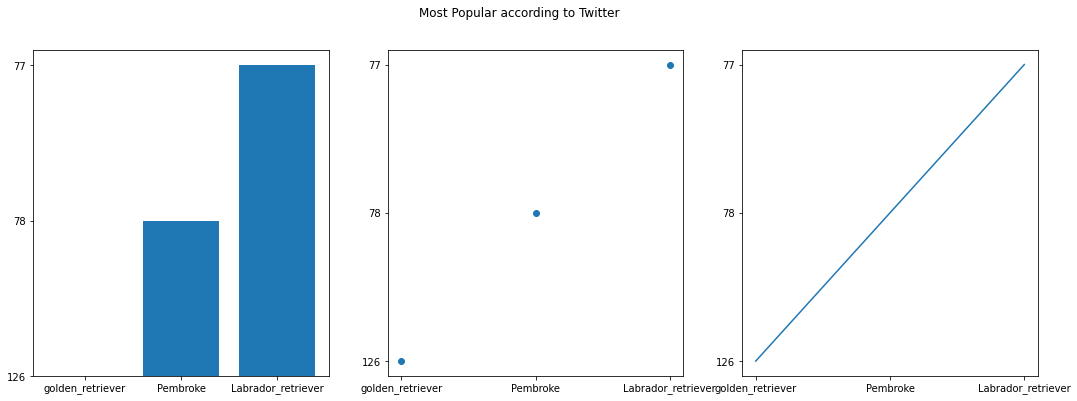

In [233]:
# Make a chart  
import matplotlib.pyplot as plt

%matplotlib inline

#names = ['group_a', 'group_b', 'group_c']
#values = [1, 10, 100]

plt.figure(1, figsize=(18, 6))

plt.subplot(131)
plt.bar(pop_dogs, num_tweets)
plt.subplot(132)
plt.scatter(pop_dogs, num_tweets)
plt.subplot(133)
plt.plot(pop_dogs, num_tweets)
plt.suptitle('Most Popular according to Twitter')
plt.show()

B Most popular and Least popular dog's names

In [234]:
#Find the most popular dog's name 
twitter_archive_copy['name'].mode()

0    Cooper
Name: name, dtype: object

In [235]:
#Find the least popular dog's name
twitter_archive_copy['name'].sort_values().head(3)

505     Abby
980     Acro
666    Adele
Name: name, dtype: object

In [236]:
#Find 3 most popular dog's names 
twitter_archive_copy['name'].value_counts().head(3)

Cooper     9
Charlie    8
Oliver     7
Name: name, dtype: int64

C Most popular used to describe a dogs' stages.

In [237]:
#Most popular slang or dog's stage 
twitter_archive_copy['dog'].value_counts()

                   1005
  pupper            119
doggo                39
   puppo             18
 floofer              6
doggo  pupper         5
doggo   puppo         1
doggo floofer         1
Name: dog, dtype: int64